# About this notebook



---



---



# Imports

In [ ]:
# Mount YOUR google drive. You'll need to "Add shortcut to Drive" for our shared folder for it to show up here.
# Use the URL shown below in the output to authorize this Colab session to access you GDrive
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

# Modify this according to the path in your computer
data_dir = '/content/drive/MyDrive/SURI/Studies/2022_Wildfires/' # <-- change this to reflect the pathing in your machine

Mounted at /content/drive/


In [ ]:
# Import needed packages
! pip install geopandas
! pip install geopy
! pip install -U plotly
! pip install cmcrameri
! pip install cpi
! pip install requests
!pip install adjustText

import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopy.distance
from shapely.geometry import Point, Polygon
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from scipy import stats as sts
import plotly.express as px
from numpy.random import default_rng
from plotnine import *
import time
from cmcrameri import cm
import cpi
import requests 

rng = default_rng(13)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 3.0 MB/s 
     |████████████████████████████████| 16.7 MB 20.4 MB/s 
     |████████████████████████████████| 6.3 MB 35.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.2 MB 4.8 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 134 kB 2.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 28.9 MB 1.2 MB/s 
Lookin

/usr/local/lib/python3.7/dist-packages/cpi/__init__.py:46: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


In [ ]:
response = requests.get("https://www.fema.gov/api/open/v1/IndividualAssistanceHousingRegistrantsLargeDisasters")
print(response.status_code)
from pandas import json_normalize 
df = pd.json_normalize(response.json()['IndividualAssistanceHousingRegistrantsLargeDisasters'])

200


# Building Inventory

## Year built

In [ ]:
def setYearBuiltFromDistribution(s,p,n):
    # s: vector of states which may represent the decade the building was built, e.g., [1940,1950,1960]
    # p: vector of probabilities of being of each state - should be the same size as s 
    # n: number of buildings

    # normalize p
    p = [float(i)/sum(p) for i in p]
    return rng.choice(s, p=p, size=n, replace=True)

## Building code

In [ ]:
# From Hazus Inventory Technical Manual Section XXX
def f_code(bld_age):
  bld_code = 'Post1940'
  if (bld_age < 1940):
    bld_code = 'Pre1940'
  elif (bld_age > 1980):
    bld_code = 'Post1980'
  
  return bld_code

## Construction class

In [ ]:
# From Hazus Inventory Technical Manual Section XXX
def setConstructionClassFromHazus(input_df):
    # ir: income ration

    s = ['Luxury','Custom','Average','Economic']
    p = []
    v = ['None'] * len(input_df.index)

    for i in range(len(input_df)):
        ir = input_df.loc[i,'IncomeRatio']

        if ir < 0.5:
            p = [0,0,0,1]

        elif 0.5 <= ir < 0.85: 
            p = [0,0,0.25,0.75]

        elif 0.85 <= ir < 1.25: 
            p = [0,0.25,0.75,0]

        elif 1.25 <= ir < 2.0: 
            p = [0,1,0,0]

        else: 
            p = [1,0,0,0]

        v[i] = rng.choice(s, p=p, size=1, replace=True)[0]

    return v

## Number to stories

In [ ]:
def setStoriesFromHazus(region,input_df):
    # From Section 5.5.6 in the Hazus Inventory Technical Manual
    # region: Northeast, Midwest, South, or West
    # occupancy: RES1 for detached buildings, RES3A and RES3B for duplexes and triplexes
    # n: number of buildings

    # The number of stories is defined according to the Hazus Inventory Manual
    # Values from Table 5-4 Hazus Inventory manual
    s_stories = []
    p_stories = []
    v = [0] * len(input_df.index)
    
    for i in range(len(input_df.index)):

        occupancy = input_df.loc[i,'Occupancy']

        if occupancy == 'RES1':
            if region == 'Northeast':
                s_stories = [1, 2, 3]
                p_stories = [0.25,0.68,0.05] 

            elif region == 'Midwest':
                s_stories = [1, 2, 3]
                p_stories = [0.50,0.46,0.02]

            elif region == 'South':
                s_stories = [1, 2, 3]
                p_stories = [0.66,0.32,0.01]

            else: # West
                s_stories = [1, 2, 3]
                p_stories = [0.66,0.30,0.02]

            p_stories = [float(i)/sum(p_stories) for i in p_stories]
            v[i] = rng.choice(s_stories, p=p_stories, size=1, replace=True)[0]

        # RES3 building fall into two categories 1-2, and 3-4 stories
        else:
            if region == 'Northeast':
                s_stories = [1,3]
                p_stories = [0.29,0.26] 

            elif region == 'Midwest':
                s_stories = [1,3]
                p_stories = [0.49,0.29]

            elif region == 'South':
                s_stories = [1,3]
                p_stories = [0.66,0.21]

            else: # West
                s_stories = [1,3]
                p_stories = [0.58,0.25]

            p_stories = [float(i)/sum(p_stories) for i in p_stories]
            v[i] = int(rng.choice(s_stories, p=p_stories, size=1, replace=True)[0] + round(rng.random()))

    return v

## Basement

In [ ]:
def setBasementFromHazus(region,n):
    # From Tables 5-3 and 5-6 in the Hazus Inventory Technical Manual
    # region: region in the United States
    # n: number of buildings
    s = [True, False]
    p = []

    if region == 'New England':
        p = [0.72,0.28]

    elif region == 'Mid Atlantic':
        p = [0.58,0.42]

    elif region == 'East North Central':
        p = [0.57,0.42]

    elif region == 'West North Central':
        p = [0.56,0.44]

    elif region == 'South Atlantic':
        p = [0.19,0.81]

    elif region == 'East South Central':
        p = [0.18,0.82]

    elif region == 'West South Central':
        p = [0.02,0.98]

    elif region == 'Mountain':
        p = [0.26,0.74]

    else: # West
        p = [0.08, 0.92]

    p = [float(i)/sum(p) for i in p]  
    return rng.choice(s, p=p, size=n, replace=True)

## Area

In [ ]:
def setAreaFromHazus(region,df_input):
    # From Table 5-2 in the Hazus Inventory Technical Manual
    # region: census region
    # n: number of buildings
    # ir: income ratio
    # bsm: presence of basement, True or False
    # occ: occupancy
    # units: number of units in multi-unit buildings

    n = len(df_input.index)
    ir = df_input['IncomeRatio']
    bsm = df_input['Basement']
    occ = df_input['Occupancy']
    units = df_input['Units']
    area = [0] * n

    for i in range(n):
        if occ[i] == 'RES1':
            if region == 'New England':
                if ir[i] < 0.5:
                    if bsm[i] == False:
                        area[i] = 1300
                    else:
                        area[i] = 975

                elif 0.5 <= ir[i] < 0.85:
                    if bsm[i] == False:
                        area[i] = 1500
                    else:
                        area[i] = 1125

                elif 0.85 <= ir[i] < 1.25:
                    if bsm[i] == False:
                        area[i] = 1800
                    else:
                        area[i] = 1350

                elif 1.25 <= ir[i] < 2:
                    if bsm[i] == False:
                        area[i] = 1900
                    else:
                        area[i] = 1425

                else:
                    if bsm[i] == False:
                        area[i] = 2200
                    else:
                        area[i] = 1650

            elif region == 'Middle Atlantic':
                if ir[i] < 0.5:
                    if bsm[i] == False:
                        area[i] = 1300
                    else:
                        area[i] = 975

                elif 0.5 <= ir[i] < 0.85:
                    if bsm[i] == False:
                        area[i] = 1500
                    else:
                        area[i] = 1125

                elif 0.85 <= ir[i] < 1.25:
                    if bsm[i] == False:
                        area[i] = 1700
                    else:
                        area[i] = 1275

                elif 1.25 <= ir[i] < 2:
                    if bsm[i] == False:
                        area[i] = 1900
                    else:
                        area[i] = 1425

                else:
                    if bsm[i] == False:
                        area[i] = 2200
                    else:
                        area[i] = 1650

            elif region == 'East North Central':
                if ir[i] < 0.5:
                    if bsm[i] == False:
                        area[i] = 1300
                    else:
                        area[i] = 975

                elif 0.5 <= ir[i] < 0.85:
                    if bsm[i] == False:
                        area[i] = 1600
                    else:
                        area[i] = 1200

                elif 0.85 <= ir[i] < 1.25:
                    if bsm[i] == False:
                        area[i] = 1700
                    else:
                        area[i] = 1275

                elif 1.25 <= ir[i] < 2:
                    if bsm[i] == False:
                        area[i] = 1800
                    else:
                        area[i] = 1350

                else:
                    if bsm[i] == False:
                        area[i] = 2500
                    else:
                        area[i] = 1875

            elif region == 'West North Central':
                if ir[i] < 0.5:
                    if bsm[i] == False:
                        area[i] = 1300
                    else:
                        area[i] = 975

                elif 0.5 <= ir[i] < 0.85:
                    if bsm[i] == False:
                        area[i] = 1500
                    else:
                        area[i] = 1125

                elif 0.85 <= ir[i] < 1.25:
                    if bsm[i] == False:
                        area[i] = 1800
                    else:
                        area[i] = 1350

                elif 1.25 <= ir[i] < 2:
                    if bsm[i] == False:
                        area[i] = 1800
                    else:
                        area[i] = 1350

                else:
                    if bsm[i] == False:
                        area[i] = 2300
                    else:
                        area[i] = 1725

            elif region == 'South Atlantic':
                if ir[i] < 0.5:
                    if bsm[i] == False:
                        area[i] = 1400
                    else:
                        area[i] = 1050

                elif 0.5 <= ir[i] < 0.85:
                    if bsm[i] == False:
                        area[i] = 1600
                    else:
                        area[i] = 1200

                elif 0.85 <= ir[i] < 1.25:
                    if bsm[i] == False:
                        area[i] = 1700
                    else:
                        area[i] = 1275

                elif 1.25 <= ir[i] < 2:
                    if bsm[i] == False:
                        area[i] = 2000
                    else:
                        area[i] = 1500

                else:
                    if bsm[i] == False:
                        area[i] = 2300
                    else:
                        area[i] = 1725

            if region == 'East South Central':
                if ir[i] < 0.5:
                    if bsm[i] == False:
                        area[i] = 1300
                    else:
                        area[i] = 975

                elif 0.5 <= ir[i] < 0.85:
                    if bsm[i] == False:
                        area[i] = 1400
                    else:
                        area[i] = 1050

                elif 0.85 <= ir[i] < 1.25:
                    if bsm[i] == False:
                        area[i] = 1700
                    else:
                        area[i] = 1275

                elif 1.25 <= ir[i] < 2:
                    if bsm[i] == False:
                        area[i] = 1900
                    else:
                        area[i] = 1425

                else:
                    if bsm[i] == False:
                        area[i] = 2500
                    else:
                        area[i] = 1875

            if region == 'West South Central':
                if ir[i] < 0.5:
                    if bsm[i] == False:
                        area[i] = 1300
                    else:
                        area[i] = 975

                elif 0.5 <= ir[i] < 0.85:
                    if bsm[i] == False:
                        area[i] = 1700
                    else:
                        area[i] = 1275

                elif 0.85 <= ir[i] < 1.25:
                    if bsm[i] == False:
                        area[i] = 1800
                    else:
                        area[i] = 1350

                elif 1.25 <= ir[i] < 2:
                    if bsm[i] == False:
                        area[i] = 1900
                    else:
                        area[i] = 1425

                else:
                    if bsm[i] == False:
                        area[i] = 2500
                    else:
                        area[i] = 1875

            elif region == 'Mountain':
                if ir[i] < 0.5:
                    if bsm[i] == False:
                        area[i] = 1200
                    else:
                        area[i] = 900

                elif 0.5 <= ir[i] < 0.85:
                    if bsm[i] == False:
                        area[i] = 1500
                    else:
                        area[i] = 1125

                elif 0.85 <= ir[i] < 1.25:
                    if bsm[i] == False:
                        area[i] = 1700
                    else:
                        area[i] = 1275

                elif 1.25 <= ir[i] < 2:
                    if bsm[i] == False:
                        area[i] = 1800
                    else:
                        area[i] = 1350

                else:
                    if bsm[i] == False:
                        area[i] = 2600
                    else:
                        area[i] = 1950

            else: # West
                if ir[i] < 0.5:
                    if bsm[i] == False:
                        area[i] = 1300
                    else:
                        area[i] = 975

                elif 0.5 <= ir[i] < 0.85:
                    if bsm[i] == False:
                        area[i] = 1500
                    else:
                        area[i] = 1125

                elif 0.85 <= ir[i] < 1.25:
                    if bsm[i] == False:
                        area[i] = 1700
                    else:
                        area[i] = 1275

                elif 1.25 <= ir[i] < 2:
                    if bsm[i] == False:
                        area[i] = 1900
                    else:
                        area[i] = 1425

                else:
                    if bsm[i] == False:
                        area[i] = 2100
                    else:
                        area[i] = 1575
        elif occ[i] == 'RES3A' or occ[i] == 'RES3B':

            if region == 'Northeast':
                area[i] = 1191 * units[i]
            elif region == 'Midwest':
                area[i] = 1279 * units[i]
            elif region == 'South':
                area[i] = 945 * units[i]
            else: #West
                area[i] = 930 * units[i]

        else: #RES3C-RES3F
            if region == 'Northeast':
                area[i] = 849 * units[i]
            elif region == 'Midwest':
                area[i] = 787 * units[i]
            elif region == 'South':
                area[i] = 916 * units[i]
            else: #West
                area[i] = 811 * units[i]

    return area

## Replacement cost

In [ ]:
def setReplacementCostFromHazus(input_df):
    # From Section 5.9.2 in the Hazus Inventory Technical Manual
    # Assumption
    bsm_finish = True
    
    v = [0] * len(input_df.index)

    for i in range(len(input_df.index)):

        bld_occ     = input_df.loc[i,'Occupancy']
        const_class = str(input_df.loc[i,'ConstructionClass'])
        bld_area    = input_df.loc[i,'Area']
        n_storeys   = input_df.loc[i,'Stories']
        bsm_flag    = input_df.loc[i,'Basement']

        # Basement
        bsm_area = 0.0
        if (bsm_flag == True):
            bsm_area = bld_area * 0.25

        # Garage
        p = [1/3,1/3,1/3]
        
        
        # Adapted from Building Portfolio Manual Table 6.3
        bld_value = 0.0
        if (bld_occ == 'RES1'):
            if (const_class == 'Economic'):
                s = [18676,29263,39580]
                grg_value = rng.choice(s,p=p,size=1)[0]

                if n_storeys == 1:
                    bsm_value = 26.45 * bsm_area if bsm_finish == True else 9.55 * bsm_area 
                    bld_value = 97.61 * bld_area + bsm_value + grg_value
                elif n_storeys == 2:
                    bsm_value = 15.20 * bsm_area if bsm_finish == True else 6.30 * bsm_area
                    bld_value = 104.04 * bld_area + bsm_value + grg_value
                elif n_storeys >= 3:
                    bsm_value = 15.20 * bsm_area if bsm_finish == True else 6.30 * bsm_area
                    bld_value = 104.04 * bld_area + bsm_value + grg_value
                    

            elif (const_class == 'Average'):
                s = [19410,30224,40768]
                grg_value = rng.choice(s,p=p,size=1)[0]

                if n_storeys == 1:
                    bsm_value = 32.80 * bsm_area if bsm_finish == True else 11.25 * bsm_area
                    bld_value = 116.66 * bld_area + bsm_value + grg_value
                elif n_storeys == 2:
                    bsm_value = 21.05 * bsm_area if bsm_finish == True else 7.30 * bsm_area
                    bld_value = 122.75 * bld_area + bsm_value + grg_value
                elif n_storeys >= 3:
                    bsm_value = 16.65 * bsm_area if bsm_finish == True else 5.80 * bsm_area
                    bld_value = 127.94 * bld_area + bsm_value + grg_value
                    

            elif (const_class == 'Custom'):
                s = [21577,34319,46713]
                grg_value = rng.choice(s,p=p,size=1)[0]

                if n_storeys == 1:
                    bsm_value = 53.65 * bsm_area if bsm_finish == True else 21.65 * bsm_area
                    bld_value = 159.51 * bld_area + bsm_value + grg_value
                elif n_storeys == 2:
                    bsm_value = 30.90 * bsm_area if bsm_finish == True else 12.90 * bsm_area
                    bld_value = 163.95 * bld_area + bsm_value + grg_value
                elif n_storeys >= 3:
                    bsm_value = 22.55 * bsm_area if bsm_finish == True else 9.60 * bsm_area 
                    bld_value = 168.69 * bld_area + bsm_value + grg_value
                    

            elif (const_class == 'Luxury'):
                s = [25105,40136,54821]
                grg_value = rng.choice(s,p=p,size=1)[0]

                if n_storeys == 1:
                    bsm_value = 59.00 * bsm_area if bsm_finish == True else 22.65 * bsm_area
                    bld_value = 188.84 * bld_area + bsm_value + grg_value
                elif n_storeys == 2:
                    bsm_value = 34.55 * bsm_area if bsm_finish == True else 13.85 * bsm_area
                    bld_value = 194.94 * bld_area + bsm_value + grg_value
                elif n_storeys >= 3:
                    bsm_value = 25.50 * bsm_area if bsm_finish == True else 10.40 * bsm_area 
                    bld_value = 201.09 * bld_area + bsm_value + grg_value


        # Adapted from Building Portfolio Manual Table 6.2
        elif ('RES3' in bld_occ):
            if ('A' in bld_occ):
                bld_value = 124.25 * bld_area
            elif ('B' in bld_occ):
                bld_value = 109.66 * bld_area  
            elif ('C' in bld_occ):
                bld_value = 201.33 * bld_area
            elif ('D' in bld_occ):
                bld_value = 187.75 * bld_area
            elif ('E' in bld_occ):
                bld_value = 188.48 * bld_area
            elif ('F' in bld_occ):
                bld_value = 174.53 * bld_area
        else:
            print('I do not recognize building type ', bld_occ)
            
        v[i] = bld_value * 1.1 #10% added for resilience improvements as per HCD page 17
        #print(bld_value)

    return v



---



---



### Get building inventory

In [ ]:
def getBuildingInventoryFromHazus(county,mode):
    df = pd.DataFrame()

    # Damage multiplier
    dest = [1] * dic_destroyed[str(county)]
    dmg = [0.625] * dic_damaged[str(county)]
    dest.extend(dmg)
    df['DamageMultiplier'] = dest

    # Building value, Figure 63 HCD document 
    dic_home_val = {'Butte': 228500,
                'Lake': 167300,
                'Los Angeles': 465000,
                'Mendocino': 319100,
                'Napa': 503000,
                'Nevada': 355900,
                'San Diego': 454600,
                'Santa Barbara': 480000,
                'Sonoma': 464700,
                'Ventura': 481400,
                'Yuba': 190650
                }
    mean_home_value = 459650
    home_value_adj_factor =  dic_home_val[county] / mean_home_value
    
    ami = dic_HINCs[str(county)]   
    ami_CA = 75235
    ami_West = 72464
    ami_US = 67521
    n = dic_destroyed[str(county)] + dic_damaged[str(county)]

    # Units
    df['Units'] = [1] * n

    # Income ratio
    ir = ami/ami_US
    df['IncomeRatio'] = [ir] * n

    # RES1 indicates residential building
    df['Occupancy'] = df['Units'].apply(lambda x: 'RES1' if x == 1 else ('RES3A' if x == 2 else 'RES3B'))

    # Residence type
    df['residenceType'] = df['Occupancy'].apply(lambda x: 'House/Duplex' if x == 'RES1' else 'Unknown')

    # Number of stories
    df['Stories'] = setStoriesFromHazus('West',df)

    # Basement
    df['Basement'] = setBasementFromHazus('West',len(df.index))

    # Area
    df['Area'] = setAreaFromHazus('West',df)

    # Construction class
    df['ConstructionClass'] = setConstructionClassFromHazus(df)

    if mode=='Hazus':
        # Replacement cost
        df['ReplacementCost'] = setReplacementCostFromHazus(df) 

    else:
        df['ReplacementCost'] =  [300000] * n  

    # FEMA verified losses, calculate in 2018 dollars
    df['FLV'] = (0.05 + rng.random() * 0.05) * df['ReplacementCost']

    # inflation
    df['ReplacementCost'] = df['ReplacementCost']

    # county adjustment factor
    df['ReplacementCost'] = df['ReplacementCost'] * home_value_adj_factor

    # damage
    df['RepairCost'] = df['ReplacementCost'] * df['DamageMultiplier']


    return df

# Insurance

In [ ]:
def getInsuranceAmount(df,insurance_deduct_pct,county):
    # number of buildings
    nblds = len(df.index)

    # insurance coverage
    # with 15% deductible coverage is maximum 85%
    ins_coverage = 0.5

    # insurance penetration
    ins_pen = min(dic_insured[str(county)] / (dic_damaged[str(county)] + dic_destroyed[str(county)]),1)

    # probability of being insured
    p=[ins_pen,1-ins_pen]
    s=[1,0]

    # Check if max coverage exceeds loss
    v = [0] * nblds
    for i in range(nblds):
        max_coverage = (ins_coverage - insurance_deduct_pct) * df.loc[i,'ReplacementCost']

        # No insurance
        # v[i] = 0

        # Full insurance
        #v[i] = (1 - insurance_deduct_pct) * df.loc[i,'RepairCost']

        # Partial insurance
        v[i] = df.loc[i,'RepairCost'] if max_coverage > df.loc[i,'RepairCost'] else max_coverage

    return v * rng.choice(s, p=p, size=nblds, replace=True)

# Small Business Adminstration

## Approval rates

### Get hold of the data and clean it

In [ ]:
SBA_dir = data_dir + 'SBA/'

# Approved loans
df_approvals = pd.read_csv(SBA_dir + "data/sba_disaster_loan_approvals.csv.gz")

# Withdrawn loans
df_withdrawals = pd.read_csv(SBA_dir + "data/sba_disaster_loan_withdrawals.csv.gz")

# Declined loans
df_declines = pd.read_csv(SBA_dir + "data/sba_disaster_loan_declines.csv.gz")

# Remove whitespace from decline code fields
df_declines[['DECL_CODES','DECL_CODES2','DECL_CODES3','DECL_CODES4','FEMA_DECL']] = df_declines[['DECL_CODES','DECL_CODES2','DECL_CODES3','DECL_CODES4','FEMA_DECL']].apply(lambda s: s.str.strip())

# Remove whitespace from ends of state codes
df_approvals[['STATE']] = df_approvals[['STATE']].apply(lambda s: s.str.strip())
df_withdrawals[['STATE']] = df_withdrawals[['STATE']].apply(lambda s: s.str.strip())
df_declines[['STATE']] = df_declines[['STATE']].apply(lambda s: s.str.strip())

# Looking only at HOME LOANS & LOANS BELOW 200K with FEMA verified losses
cols = ['ORIGINAL_APPROVAL_AMOUNT']
mask = df_approvals[cols].applymap(lambda x: isinstance(x, (int, float)))
df_approvals[cols] = df_approvals[cols].where(mask)
df_approvals = df_approvals[df_approvals['ORIGINAL_APPROVAL_AMOUNT'].astype(float)<210000].reset_index(drop=True)
df_approvals['FEMA_DECL'] = pd.to_numeric(df_approvals['FEMA_DECL'].str.replace('DR',''),errors='coerce')

cols = ['TOT_ORIG_VER_LOSS']
mask = df_declines[cols].applymap(lambda x: isinstance(x, (int, float)))
df_declines[cols] = df_declines[cols].where(mask)
df_declines = df_declines[(df_declines['TOT_ORIG_VER_LOSS_RE'] > 100) & (df_declines['TOT_ORIG_VER_LOSS_RE'].astype(float)<210000)]

# Remove data we would not have by 2017
df_approvals = df_approvals[df_approvals['FY'] < 2018].reset_index(drop=True)

#df_approvals['InflationRates'] = df_approvals['FY'].astype(int).apply(lambda x: cpi.inflate(1,x,to=2021)) #map(inflation_dict)
df_approvals['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'] = df_approvals['ORIGINAL_APPROVAL_AMOUNT'] #* df_approvals['InflationRates']

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,7,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,7,10,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,7,10,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Get the approval rate for the state

In [ ]:
def getApprovalRateForSelectedState(state):

    # Read
    SBA_dir = data_dir + 'SBA/'
    df_SBA_2008 = pd.read_csv(SBA_dir + "SBA_FY08.txt")
    df_SBA_2009 = pd.read_csv(SBA_dir + "SBA_FY09.txt")
    df_SBA_2010 = pd.read_csv(SBA_dir + "SBA_FY10.txt")
    df_SBA_2011 = pd.read_csv(SBA_dir + "SBA_FY11.txt")
    df_SBA_2012 = pd.read_csv(SBA_dir + "SBA_FY12.txt")
    df_SBA_2013 = pd.read_csv(SBA_dir + "SBA_FY13.txt")
    df_SBA_2014 = pd.read_csv(SBA_dir + "SBA_FY14.txt")
    df_SBA_2015 = pd.read_csv(SBA_dir + "SBA_FY15.txt")
    df_SBA_2016 = pd.read_csv(SBA_dir + "SBA_FY16.txt")
    df_SBA_2017 = pd.read_csv(SBA_dir + "SBA_FY17.txt")
    df_SBA_2018 = pd.read_csv(SBA_dir + "SBA_FY18.txt") # Not available in 2017
    df_SBA_2019 = pd.read_csv(SBA_dir + "SBA_FY19.txt") # Not available in 2017

    df_SBA_All = pd.DataFrame()
    df_SBA_All = df_SBA_All.append(df_SBA_2008[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
    df_SBA_All = df_SBA_All.append(df_SBA_2009[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
    df_SBA_All = df_SBA_All.append(df_SBA_2010[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
    df_SBA_All = df_SBA_All.append(df_SBA_2011[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
    df_SBA_All = df_SBA_All.append(df_SBA_2012[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
    df_SBA_All = df_SBA_All.append(df_SBA_2013[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
    df_SBA_All = df_SBA_All.append(df_SBA_2014[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
    df_SBA_All = df_SBA_All.append(df_SBA_2015[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
    df_SBA_All = df_SBA_All.append(df_SBA_2016[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
    df_SBA_All = df_SBA_All.append(df_SBA_2017[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
    #df_SBA_All = df_SBA_All.append(df_SBA_2018[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
    #df_SBA_All = df_SBA_All.append(df_SBA_2019[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
    df_SBA_All = df_SBA_All.dropna().reset_index(drop=True)

    df_SBA_All = df_SBA_All.rename(columns={"Damaged Property State Code": "State"})

    # All disasters between 2007 and 2019
    if state == 'All':
        df_Approvals_state = df_SBA_All.copy()
    else:  
        df_Approvals_state = df_SBA_All[df_SBA_All['State'] == 'CA'].copy()

    return len(df_Approvals_state[df_Approvals_state['Approved Amount Real Estate'] > 0].index) / len(df_Approvals_state.index)

## Approval amount

### Get hold of data and clean it

In [ ]:
# Read
SBA_dir = data_dir + 'SBA/'
df_SBA_2008 = pd.read_csv(SBA_dir + "SBA_FY08.txt")
df_SBA_2009 = pd.read_csv(SBA_dir + "SBA_FY09.txt")
df_SBA_2010 = pd.read_csv(SBA_dir + "SBA_FY10.txt")
df_SBA_2011 = pd.read_csv(SBA_dir + "SBA_FY11.txt")
df_SBA_2012 = pd.read_csv(SBA_dir + "SBA_FY12.txt")
df_SBA_2013 = pd.read_csv(SBA_dir + "SBA_FY13.txt")
df_SBA_2014 = pd.read_csv(SBA_dir + "SBA_FY14.txt")
df_SBA_2015 = pd.read_csv(SBA_dir + "SBA_FY15.txt")
df_SBA_2016 = pd.read_csv(SBA_dir + "SBA_FY16.txt")
df_SBA_2017 = pd.read_csv(SBA_dir + "SBA_FY17.txt")
df_SBA_2018 = pd.read_csv(SBA_dir + "SBA_FY18.txt")
df_SBA_2019 = pd.read_csv(SBA_dir + "SBA_FY19.txt")

df_SBA_All = pd.DataFrame()
df_SBA_All = df_SBA_All.append(df_SBA_2008[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2009[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2010[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2011[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2012[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2013[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2014[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2015[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2016[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2017[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2018[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2019[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.dropna().reset_index(drop=True)

df_SBA_All = df_SBA_All.rename(columns={"Damaged Property State Code": "State"})


# Get only the entries with an associated valid FEMA declaration number
cols = ['FEMA Disaster Number']
mask = df_SBA_All[cols].applymap(lambda x: isinstance(x, (int, float)))
df_SBA_All[cols] = df_SBA_All[cols].where(mask)
df_SBA_All['FEMA Disaster Number'] = df_SBA_All['FEMA Disaster Number'].astype(int).reset_index(drop=True)

# Get the ratio of loan-to-loss
df_SBA_All['Ratio'] = df_SBA_All['Approved Amount Real Estate']/df_SBA_All['Verified Loss Real Estate']

# Get only approved 
df_SBA_All = df_SBA_All[df_SBA_All['Approved Amount Real Estate'] > 0].reset_index(drop=True)

# If the loan approved is higher than the verified loss there is something wrong with this entry so I am removing it
# Using 1.05 to allow small adjustment to the loan amount 
df_SBA_All = df_SBA_All[df_SBA_All['Ratio'] <= 1.05].reset_index(drop=True)
print('There are',len(df_SBA_All.index),'entries in total.')

df_FEMA_Declarations = pd.read_csv('/content/drive/MyDrive/SURI/Studies/2022_Wildfires/' + "DisasterDeclarationsSummaries.csv")
df_FEMA_Declarations = df_FEMA_Declarations[df_FEMA_Declarations['fyDeclared']>2000]
df_FEMA_Declarations = df_FEMA_Declarations[df_FEMA_Declarations['declarationType'] == 'DR']

codes = df_FEMA_Declarations['disasterNumber']
years = df_FEMA_Declarations['fyDeclared']
FEMADeclaration_dict = dict(zip(codes, years))

hazard = df_FEMA_Declarations['incidentType']
FEMADeclarationHazard_dict = dict(zip(codes, hazard))

# Disaster year
df_SBA_All['Year'] = df_SBA_All['FEMA Disaster Number'].map(FEMADeclaration_dict)
df_SBA_All = df_SBA_All[df_SBA_All['Year'].isna() == False].reset_index(drop=True)

# Disaster hazard
df_SBA_All['Hazard'] = df_SBA_All['FEMA Disaster Number'].map(FEMADeclarationHazard_dict)
df_SBA_All['Hazard'] = df_SBA_All['Hazard'].replace(np.nan,'Unknown')

# Inflation rate since year
#df_SBA_All['InflationRate'] = df_SBA_All['Year'].astype(int).apply(lambda x: cpi.inflate(1,x,to=2021))

There are 16844 entries in total.


### Get the approval amount for the state

In [ ]:
def getSplitLosses(theState,theHazard,df_AllLoans,df_FOIAApprovals):

    # Split loans between individual and aggregated
    df_Ind = df_AllLoans[(df_AllLoans['Approved Amount Real Estate'] <= 210000)].copy()

    df_Agg = df_AllLoans[(df_AllLoans['Approved Amount Real Estate'] > 210000) &\
                         (df_AllLoans['State']==theState) &\
                         (df_AllLoans['Hazard']==theHazard)].copy().reset_index(drop=True)

    # Fit an exponential RV to the approved loans in the FOIA data
    df_ApprovedLoans = df_FOIAApprovals[df_FOIAApprovals['STATE'] == theState].copy()
    X = np.array(df_ApprovedLoans['ORIGINAL_APPROVAL_AMOUNT'], dtype=float)#df_ApprovedLoans['ORIGINAL_APPROVAL_AMOUNT']
    cut,mu = sts.expon.fit(X)


    # Return df
    df_return = pd.DataFrame()
    v_ratio = list(df_Ind['Ratio'])
    v_amt = list(df_Ind['Approved Amount Real Estate'])
    v_loss = list(df_Ind['Verified Loss Real Estate'])
    v_ddnumber = list(df_Ind['FEMA Disaster Number'])
    v_state = list(df_Ind['State'])
    v_year = list(df_Ind['Year'])
    v_hazard = list(df_Ind['Hazard'])


    # Loop over each aggregated entry
    for i in range(len(df_Agg.index)):

        # Get the value in this aggregated group
        totalLoan = df_Agg.loc[i,'Approved Amount Real Estate']

        # Get the interest rate for this event
        #ir = df_Agg.loc[i,'InflationRate']

        while totalLoan > 0:

            # Estimate approved amount - note, the SBA cap is 200,000
            myApprovedAmount = min(np.random.exponential(mu,1)[0],200000)

            # Fit a multinomial RV to the Loan-to-Loss ratio for the individual loan data
            theBins = list(range(0,11,1))
            theBins = [x / 10 for x in theBins]

            # Get hold of the approved amount near the randomly assigned to this building
            df_Near = df_Ind[(df_Ind['Approved Amount Real Estate'] > myApprovedAmount - 50000)\
                                                    & (df_Ind['Approved Amount Real Estate'] < myApprovedAmount + 50000)].copy()

            count, division = np.histogram(df_Near[df_Near['Ratio']>0]['Ratio'],bins=theBins)
            p = count/np.sum(count)
            s = list(range(0,10,1))
            s = [x / 10 for x in s]

            # Estimate ratio within the 0.1-brackets
            myRatio = rng.choice(s,p=p,size=1)[0] + rng.random(1)[0]/10
            
            # Main calculations
            v_ratio.append(myRatio)
            v_amt.append(myApprovedAmount)
            v_loss.append(myApprovedAmount/myRatio)

            # Others
            v_ddnumber.append(df_Agg.loc[i,'FEMA Disaster Number'])
            v_state.append(df_Agg.loc[i,'State'])
            v_year.append(df_Agg.loc[i,'Year'])
            v_hazard.append(df_Agg.loc[i,'Hazard'])

            totalLoan -= myApprovedAmount

    df_return['FEMA Disaster Number'] = v_ddnumber
    df_return['State'] = v_state
    df_return['Verified Loss Real Estate'] = v_loss
    df_return['Approved Amount Real Estate'] = v_amt
    df_return['Ratio'] = v_ratio
    df_return['Year'] = v_year
    df_return['Hazard'] = v_hazard

    return df_return

In [ ]:
def getApprovedAmountMatrixForSelectedState(state,hazard):

    df_sba = getSplitLosses(state,hazard,df_SBA_All,df_approvals)

    # Check in which bracket the losses for each applicant are
    out = pd.DataFrame()

    # Gather data for the selected state
    if str(state) == 'CA':
      lossbins = list(range(0,500001,50000))
      lossbins.append(1000000)

    else:
        # Define the loss brackets
        lossbins = list(range(0,600000,100000))
        lossbins.append(1000000)

    #print('The results are based on',len(df_State.index),'data points.')

    for i in range(len(lossbins)-1):
        df = df_sba[df_sba['Verified Loss Real Estate'].apply(lambda x: True if lossbins[i] <= x < lossbins[i+1] else False)]
        theBins = list(range(0,11,1))
        theBins = [x / 10 for x in theBins]
        count, division = np.histogram(df['Ratio'],bins=theBins)
        
        out[str(lossbins[i+1])] = count/np.sum(count)

    out.to_csv(data_dir+'ApprovalAmountMatrix.txt', index=False)
    return out

## Get SBA Loan

In [ ]:
# Home repairs
def getSBAHomeLoan(df,sba_m):

    def getSBACoeff(loss):
        df_SBA_Matrix = df_SBAApprovedAmountsForCA.copy()

        theBins = list(range(0,10,1))
        theBins = [x / 10 for x in theBins]
        s=theBins
        p = []

        ranges = df_SBA_Matrix.columns.astype(float)

        for r in range(len(ranges)):
            if loss < ranges[r]:
                p=list(df_SBA_Matrix.iloc[:,r])
                break

        p = [float(i)/sum(p) for i in p]  

        # Randomly distributed within the interval
        u = rng.random()/len(theBins)
        s = [float(i) + u for i in s]  

        return rng.choice(s,p=p,size=1,replace=True)[0]

    # Multiply approval rate by the number of persons expected to apply
    # This avoids the need to randomly select which homeowners will apply
    sba_r = the_SBAApprovalRateForCA

    # Get the SBA eligible loss
    theEligibleLoss = df['TotalLoss'] - df['Insurance'] - df['FEMA_IAP']

    # Maximum loan
    sba_max = 200000

    n = len(df.index) 
    returnVector = [0]*n

    sample_size = round(sba_m * n)
    df_sample = df.sample(sample_size)

    for i in df_sample.index:
        # Calculate funding from SBA
        sba_coef = getSBACoeff(theEligibleLoss[i])
        v = theEligibleLoss[i]
        p=[sba_r,1-sba_r]
        s=[min(sba_coef*v,sba_max),0]
        returnVector[i] = rng.choice(s, p=p, size=1, replace=True)[0]

    return returnVector 

# FEMA Individual Assistance Program

In [ ]:
FEMA_dir = data_dir + 'FEMA_IAP/'


# Uncomment this if you want to re-read the whole/large file
df_FEMA = pd.read_csv(FEMA_dir + "IndividualAssistanceHousingRegistrantsLargeDisasters.csv")
df_FEMA = df_FEMA[['disasterNumber','damagedCity','damagedStateAbbreviation','censusBlockId','householdComposition','ownRent','residenceType','homeOwnersInsurance','grossIncome',\
                    'primaryResidence','ppfvl','rpfvl','rentalAssistanceAmount','repairAmount','replacementAmount']]


# Drop anyone without Real Property FEMA Verified Losses because they are automatically denied assistance
df_FEMA[pd.to_numeric(df_FEMA['rpfvl'], errors='coerce').notnull()]
df_FEMA = df_FEMA[df_FEMA['rpfvl'].isna() == False]
df_FEMA = df_FEMA[df_FEMA['rpfvl'].astype(int) > 0].reset_index(drop=True)


# Remove data not available in 2017
df_FEMA_IHP = df_FEMA[~df_FEMA['disasterNumber'].isin(['4344','4353'])].reset_index(drop=True)

In [ ]:
# Make a copy of the original data
df_FEMA_IHP = df_FEMA.copy()


# Remove 'NaN' income
df_FEMA_IHP['grossIncome'] = df_FEMA_IHP['grossIncome'].fillna(-1)
#df_FEMA_IHP = df_FEMA_IHP[~df_FEMA_IHP['grossIncome'].isin(['NaN','nan'])].reset_index(drop=True)


# Remove 'NaN' repair/repair amount
#df_FEMA_IHP = df_FEMA_IHP[df_FEMA_IHP['repairAmount'].notna()].reset_index(drop=True)
df_FEMA_IHP['repairAmount'] = df_FEMA_IHP['repairAmount'].fillna(0)
df_FEMA_IHP['replacementAmount'] = df_FEMA_IHP['replacementAmount'].fillna(0)
df_FEMA_IHP['totalAmount'] = df_FEMA_IHP['repairAmount'] + df_FEMA_IHP['replacementAmount']


# Clean loss data 'NaN' loss
df_FEMA_IHP = df_FEMA_IHP[df_FEMA_IHP['rpfvl'].notna()].reset_index(drop=True)
df_FEMA_IHP['rpfvl'] = df_FEMA_IHP['rpfvl'].apply(lambda x: 1000000 if x > 1000000 else x)


# Remove mobile homes
df_FEMA_IHP = df_FEMA_IHP[df_FEMA_IHP['residenceType'] != 'Mobile Home'].reset_index(drop=True)


# Remove data for Puerto Rico as losses/incomes are very different from continental US
df_FEMA_IHP = df_FEMA_IHP[df_FEMA_IHP['damagedStateAbbreviation'] != 'PR'].reset_index(drop=True)


# Disaster year
df_FEMA_Declarations = pd.read_csv('/content/drive/MyDrive/SURI/Studies/2022_Wildfires/' + "DisasterDeclarationsSummaries.csv")
df_FEMA_Declarations = df_FEMA_Declarations[df_FEMA_Declarations['fyDeclared']>2000]
df_FEMA_Declarations = df_FEMA_Declarations[df_FEMA_Declarations['declarationType'] == 'DR']
codes = df_FEMA_Declarations['disasterNumber']
years = df_FEMA_Declarations['fyDeclared']
FEMADeclaration_dict = dict(zip(codes, years))
df_FEMA_IHP['Year'] = df_FEMA_IHP['disasterNumber'].map(FEMADeclaration_dict)

# Grant to loss ratio
df_FEMA_IHP['Ratio'] = df_FEMA_IHP['totalAmount'] / df_FEMA_IHP['rpfvl']
df_FEMA_IHP['Ratio'] = df_FEMA_IHP['Ratio'].apply(lambda x: 1 if x > 1 else x)

# Inflation rates
#df_FEMA_IHP['InflationRates'] = df_FEMA_IHP['Year'].astype(int).apply(lambda x: cpi.inflate(1,x,to=2021))

# Income and loss in 2022 dollars
df_FEMA_IHP['grossIncome'] = df_FEMA_IHP['grossIncome'] #* df_FEMA_IHP['InflationRates']
df_FEMA_IHP['totalAmount'] = df_FEMA_IHP['totalAmount'] #* df_FEMA_IHP['InflationRates']
df_FEMA_IHP['rentalAssistanceAmount'] = df_FEMA_IHP['rentalAssistanceAmount'] #* df_FEMA_IHP['InflationRates']


# Disaster code
dic_disaster = {4332: 'Harvey',
                4337: 'Irma',
                4339: 'Maria',
                4559: 'Laura',
                4611: 'Ida',
                4399: 'Michael',
                4586: 'Texas Winter Storms',
                4393: 'Florence'}
#df_FEMA_IHP = df_FEMA_IHP.replace({"disasterNumber": dic_disaster})

                
# Income brackets
def getIncomeBracket(row):
    # Median household income per state
    dic_income = {'TX': 61874,
                  'PR': 19775,
                  'FL': 55660,
                  'LA': 49469,
                  'NC': 54602}


    ami = dic_income[row['damagedStateAbbreviation']]
    inc_bracket = 'None'
    if row['grossIncome'] < 0:
        inc_bracket = 'Unknown'
    elif row['grossIncome'] < 0.5*ami:
        inc_bracket = 'VeryLow'
    elif row['grossIncome'] < 0.8*ami:
        inc_bracket = 'Low'
    elif row['grossIncome'] < 1.2*ami:
        inc_bracket = 'Moderate'
    else: 
        inc_bracket = 'High'
    return inc_bracket


# Insurance
df_FEMA_IHP['homeOwnersInsurance'] = df_FEMA_IHP['homeOwnersInsurance'].apply(lambda x: 'Insured' if x == 1 else 'Uninsured')

# Residence type
df_FEMA_IHP['residenceType'] = df_FEMA_IHP['residenceType'].apply(lambda x: x if x in ['House/Duplex','Condo','Townhouse'] else 'Other')


df_FEMA_IHP['IncomeBracket'] = df_FEMA_IHP.apply(lambda row: getIncomeBracket(row), axis=1)
df_FEMA_IHP = df_FEMA_IHP[df_FEMA_IHP['IncomeBracket'] != 'Unknown'].reset_index(drop=True)

In [ ]:
n = 4586
print(df_FEMA_IHP[df_FEMA_IHP['disasterNumber'] == n]['rentalAssistanceAmount'].sum()/10**6+\
      df_FEMA_IHP[df_FEMA_IHP['disasterNumber'] == n]['replacementAmount'].sum()/10**6+\
      df_FEMA_IHP[df_FEMA_IHP['disasterNumber'] == n]['repairAmount'].sum()/10**6)
print(df_FEMA_IHP[df_FEMA_IHP['disasterNumber'] == n]['rentalAssistanceAmount'].sum()/10**6)
print(df_FEMA_IHP[df_FEMA_IHP['disasterNumber'] == n]['replacementAmount'].sum()/10**6)
print(df_FEMA_IHP[df_FEMA_IHP['disasterNumber'] == n]['repairAmount'].sum()/10**6)

78.01861194
27.95569547
0.072
49.99091647


In [ ]:
n = 4586
print(df_FEMA_IHP['rentalAssistanceAmount'].sum()/10**6+\
      df_FEMA_IHP['replacementAmount'].sum()/10**6+\
      df_FEMA_IHP['repairAmount'].sum()/10**6)
print(df_FEMA_IHP['rentalAssistanceAmount'].sum()/10**6)
print(df_FEMA_IHP['replacementAmount'].sum()/10**6)
print(df_FEMA_IHP['repairAmount'].sum()/10**6)

1496.5350534199995
311.23765660999993
17.681349469999994
1167.6160473399996


## Approval rates

In [ ]:
# Filter data
def filterIHPData(df,income,residenceType,insurance,loss,state,what):

    df_bkp = df.copy()

    # filter by income
    if income in df['IncomeBracket'].unique():
        df = df[df['IncomeBracket'] == income]

    # filter by residenceType
    if residenceType in df['residenceType'].unique():
        df = df[df['residenceType'] == residenceType]

    # filter by state
    if state in df['damagedStateAbbreviation'].unique():
        df = df[df['damagedStateAbbreviation'] == state]

    # filter by insurance
    if insurance in df['homeOwnersInsurance'].unique():
        df = df[df['homeOwnersInsurance'] == insurance]

    # filter by rpfvl
    df = df[(df['rpfvl'] >= loss-10000) & (df['rpfvl'] < loss)]

    if len(df.index) < 100:
        print('Warning: small dataset!',income,residenceType,state,insurance)
        df = df_bkp

    if what == 'amount':
        # approval amount
        return df[df['totalAmount']>0]['totalAmount'].mean()
    
    elif what == 'approvalrate':
        return len(df[df['totalAmount']>0].index)/len(df.index)

In [ ]:
# Approval rate
def getFEMAApprovalRateMatrix(state):

    # Calculate the approval rates once
    df_ApprovalRates = pd.DataFrame()

    # Loss brackets
    loss_brackets = [10000,20000,30000,40000]

    income = []
    housing = []
    insurance = []
    loss = []
    values = []
    for i in df_FEMA_IHP['IncomeBracket'].unique():
        for j in df_FEMA_IHP['residenceType'].unique():
            for k in df_FEMA_IHP['homeOwnersInsurance'].unique():
                for l in loss_brackets:
                    income.append(i)
                    housing.append(j)
                    insurance.append(k)
                    loss.append(l)
                    values.append(filterIHPData(df_FEMA_IHP,i,j,k,l,state,'approvalrate'))
                    #print(str(i)+'_'+str(j)+'_'+str(k),getApprovalRate(df_FEMA_Selected,i,j,'CA',k))

    df_ApprovalRates['Income'] = income
    df_ApprovalRates['Residence Type'] = housing
    df_ApprovalRates['Insurance Status'] = insurance
    df_ApprovalRates['Loss'] = loss
    df_ApprovalRates['Approval Rates'] = values
    df_ApprovalRates.to_csv(data_dir+ 'FEMA_IAP/' + 'df_ApprovalRates.txt')

    return df_ApprovalRates


# Select the approval rate based on demographics
def getIHPApprovalRate(df,income,residence,insurance,loss):

    loss_cat = 10000 if loss < 10000 else (20000 if loss < 20000 else (30000 if loss < 30000 else 40000))

    idx = np.where((df['Income'] == income) &\
              (df['Residence Type'] == residence) &\
              (df['Insurance Status'] == insurance) &\
              (df['Loss'] == loss_cat))

    return float(df.loc[idx,'Approval Rates'])

## Approval amount

In [ ]:
# Approval amount
def getFEMAApprovedAmountMatrix(state):

    # Calculate the approval rates once
    df_ApprovalAmount = pd.DataFrame()

    # Loss brackets
    loss_brackets = [10000,20000,30000,40000]

    income = []
    housing = []
    insurance = []
    loss = []
    values = []
    for i in df_FEMA_IHP['IncomeBracket'].unique():
        for j in df_FEMA_IHP['residenceType'].unique():
            for k in df_FEMA_IHP['homeOwnersInsurance'].unique():
                for l in loss_brackets:
                    income.append(i)
                    housing.append(j)
                    insurance.append(k)
                    loss.append(l)
                    values.append(filterIHPData(df_FEMA_IHP,i,j,k,l,state,'amount'))
                    #print(str(i)+'_'+str(j)+'_'+str(k),getApprovalRate(df_FEMA_Selected,i,j,'CA',k))

    df_ApprovalAmount['Income'] = income
    df_ApprovalAmount['Residence Type'] = housing
    df_ApprovalAmount['Insurance Status'] = insurance
    df_ApprovalAmount['Loss'] = loss
    df_ApprovalAmount['Approved Amount'] = values
    df_ApprovalAmount.to_csv(data_dir+ 'FEMA_IAP/' + 'df_ApprovedAmount.txt')

    return df_ApprovalAmount


# Select the approval rate based on demographics
def getIHPApprovedAmount(df,income,residence,insurance,loss):
    loss_cat = 10000 if loss < 10000 else\
                (20000 if loss < 20000 else\
                 (30000 if loss < 30000 else 40000))
    
    idx = np.where((df['Income'] == income) &\
              (df['Residence Type'] == residence) &\
              (df['Insurance Status'] == insurance) &\
              (df['Loss'] == loss_cat))

    return float(df.loc[idx,'Approved Amount'])

## Get FEMA Grant

In [ ]:
def getFEMAGrant(df,state,fema_m):

    # Maximum grant
    fema_max = 34000 # inflation
    n = round(len(df.index)*fema_m)
    returnApproval = [0] * len(df.index)
    returnAmount = [0] * len(df.index)

    # Eligible loss
    theEligibleLoss = df['TotalLoss'] - df['Insurance']

    df = df.sample(n)
    for i in df.index:

        # Assumption
        myInsuranceStatus = 'Insured' if df.loc[i,'Insurance'] > 0 else 'Uninsured'

        # Approval rate
        fema_approval = getIHPApprovalRate(df_FEMAIHPAppovalRates,df.loc[i,'HomeownerIncomeBracket'],df.loc[i,'residenceType'],myInsuranceStatus,df.loc[i,'FLV'])
        fema_approval *= fema_m # to account for the fact that only fema_m applied with any FVL
        p = [1-fema_approval,fema_approval]
        s = [0,1]

        # Amount approved
        fema_amount = min(fema_max,getIHPApprovedAmount(df_FEMAIHPApprovedAmounts,df.loc[i,'HomeownerIncomeBracket'],df.loc[i,'residenceType'],myInsuranceStatus,df.loc[i,'FLV']))

        returnApproval[i] = fema_approval

        returnAmount[i] = min(fema_amount,theEligibleLoss[i]) # the fema data was already inflated to 2021

    return returnApproval,returnAmount
    #return returnAmount  

# Unmet housing needs

In [ ]:
def getUnmetNeedsForCounty(df,county,state,sims,df_Sources,sba_m,fema_m,ins_deduc):

    nblds = len(df.index)

    bld_val = dic_home_val[str(county)]
    median_local_home_value = bld_val
    f = median_local_home_value / df['ReplacementCost'].mean()
    df['BuildingValue'] = f * df['ReplacementCost']


    # Save file
    ids = list(range(1,nblds+1))
    df.insert(0,'index',ids)


    # Get county data
    county_puma = dic_PUMAs[str(county)]      
    ami = dic_HINCs[str(county)]   


    # Estimate owner income
    from scipy.stats import expon


    # Get hold of ACS Data
    df_ACS = pd.read_csv(data_dir +"ACS_Income_vs_Value.csv", delim_whitespace=False, header=0)


    # Remove NaN
    df_ACS.dropna(inplace=True)
    df_ACS = df_ACS.reset_index(drop=True)


    # Select data for the county of interest
    mask = df_ACS['PUMA'].isin(county_puma)
    df_ACS = df_ACS[mask].reset_index(drop=True)


    # Calculate the ratio of property value-to-income for the county
    df_ACS['Ratio'] = df_ACS['VALP']/df_ACS['HINCP']


    # Remove suspiciously low income, and suspicious low property values entries - these might be outliers
    df_ACS = df_ACS[df_ACS['HINCP'] > 30000].reset_index(drop=True)
    df_ACS = df_ACS[df_ACS['VALP'] > 50000].reset_index(drop=True)


    # Fit an exponential pdf to the ratio of property value-to-income
    lc, sc = scipy.stats.expon.fit(df_ACS['Ratio'])


    # Randomly sample the ratio for each homeowner
    value_to_homeowner_income = scipy.stats.expon.rvs(loc=lc, scale=sc, size=nblds)

    df['HomeownerIncome'] =  df['BuildingValue'] / value_to_homeowner_income


    # Define the income bracket for each homeowner
    df['HomeownerIncomeBracket'] = df['HomeownerIncome'].apply(lambda x: 'VeryLow' if x < 0.5 * ami\
                                                                            else ('Low' if x < 0.8*ami\
                                                                            else ('High' if x > 1.2*ami else 'Moderate')))

    # Save outputs
    theTotalLoss = []
    theInsurance = []
    theIAP = []
    theHPPL = []
    theUnmetNeeds = []


    # Now, calculate the unmet housing needs for each individual homeowner
    for i in range(sims):
        print('Running simulation:',i,'for county:',county)


        # Total housing needs
        df['TotalLoss'] = df['RepairCost'] 


        # Insurance
        df['Insurance'] = getInsuranceAmount(df,ins_deduc,county) 


        # FEMA IAP
        if i == 0:
            df['FEMAApprovalRate'], df['FEMAApprovedAmount'] = getFEMAGrant(df,state,fema_m)
        

        df['FEMA_IAP'] = [0] * nblds
        for j in range(nblds):
            df.loc[j,'FEMA_IAP'] = df.loc[j,'FEMAApprovedAmount'] if rng.random() < df.loc[j,'FEMAApprovalRate'] else 0 


        # SBA Loans
        df['SBAHomeLoan'] = getSBAHomeLoan(df,sba_m)


        # Unmet housing needs
        df['Unmet'] = df['TotalLoss'] - (df['Insurance'] + df['FEMA_IAP'] + df['SBAHomeLoan'])


        # Results
        df_Sources.loc[i,'Losses'] += df['TotalLoss'].sum()
        df_Sources.loc[i,'FEMA_IAP'] += df['FEMA_IAP'].sum()
        df_Sources.loc[i,'Insurance'] += df['Insurance'].sum()
        df_Sources.loc[i,'SBA_Home'] += df['SBAHomeLoan'].sum()
        theTotalLoss.append(df['TotalLoss'].sum())
        theInsurance.append(df['Insurance'].sum())
        theIAP.append(df['FEMA_IAP'].sum())
        theHPPL.append(df['SBAHomeLoan'].sum())
        theUnmetNeeds.append(df['Unmet'].sum())


    return np.mean(theTotalLoss),np.std(theTotalLoss),np.mean(theUnmetNeeds),np.mean(theIAP),np.mean(theHPPL),np.mean(theInsurance),df_Sources,df

# Case study

#### Inputs

In [ ]:
# Counties
Counties = ['Butte', 'Lake','Los Angeles', 'Mendocino', 'Napa', 'Nevada', 'San Diego', 'Santa Barbara', 'Sonoma', 'Ventura', 'Yuba']
ncounties = len(Counties)

# County PUMA
dic_PUMAs = {'Butte': [701,702],
            'Lake': [3300],
            'Los Angeles': list(range(3701,3769,1)),
            'Mendocino': [3300],
            'Napa': [5500],
            'Nevada': [5700],
            'San Diego': list(range(7301,7322,1)),
            'Santa Barbara': [8301,8302,8303],
            'Sonoma': [9701,9702,9703],
            'Ventura': list(range(11101,11106,1)),
            'Yuba': [10100],
            }


# Building value
dic_home_val = {'Butte': 228500,
            'Lake': 167300,
            'Los Angeles': 465000,
            'Mendocino': 319100,
            'Napa': 503000,
            'Nevada': 355900,
            'San Diego': 454600,
            'Santa Barbara': 480000,
            'Sonoma': 464700,
            'Ventura': 481400,
            'Yuba': 190650
            }

# County AMI
dic_HINCs = {'Butte': 54972,
          'Lake': 49254,
          'Los Angeles': 71358,
          'Mendocino': 51416,
          'Napa': 92219,
          'Nevada': 68333,
          'San Diego': 82426,
          'Santa Barbara': 78925,
          'Sonoma': 87828,
          'Ventura': 89295,
          'Yuba': 59424
          }

# Destroyed
dic_destroyed = {'Butte': 38,
            'Lake': 131,
            'Los Angeles': 66,
            'Mendocino': 313,
            'Napa': 622,
            'Nevada': 29,
            'San Diego': 114,
            'Santa Barbara': 158,
            'Sonoma': 5143,
            'Ventura': 748,
            'Yuba': 143
            }

# Damaged
dic_damaged = {'Butte': 0,
            'Lake': 0,
            'Los Angeles': 9,
            'Mendocino': 0,
            'Napa': 4,
            'Nevada': 0,
            'San Diego': 2,
            'Santa Barbara': 97,
            'Sonoma': 11,
            'Ventura': 14,
            'Yuba': 0
            }

dic_insured = {'Butte': 16,
            'Lake': 97,
            'Los Angeles': 63,
            'Mendocino': 200,
            'Napa': 472,
            'Nevada': 32,
            'San Diego': 79,
            'Santa Barbara': 42,
            'Sonoma': 4963,
            'Ventura': 627,
            'Yuba': 107
            }

## Simulation

In [ ]:
# Number of simulations
nsims = 1000

# Get FEMA IHP parameters once at the begining
df_FEMAIHPAppovalRates = getFEMAApprovalRateMatrix('CA')
df_FEMAIHPApprovedAmounts = getFEMAApprovedAmountMatrix('CA')
fema_assumption = 'Low'
loss_model = 'Hazus'

# Get SBA parameters once at the begining
the_SBAApprovalRateForCA = getApprovalRateForSelectedState('CA') # approval rate for CA
df_SBAApprovedAmountsForCA = getApprovedAmountMatrixForSelectedState('CA','Fire') # approval amount matrix for CA


# Results
# Loss
df_TotalLoss = pd.DataFrame()
df_TotalLoss['Counties'] = Counties
df_TotalLoss['Mean'] = [0] * ncounties
df_TotalLoss['Std'] = [0] * ncounties


# Insurance
df_Insurance = pd.DataFrame()
df_Insurance['Counties'] = Counties
df_Insurance['Mean'] = [0] * ncounties


# FEMA IAP
df_FEMAIAP = pd.DataFrame()
df_FEMAIAP['Counties'] = Counties
df_FEMAIAP['Mean'] = [0] * ncounties


# SBA HPPL
df_SBAHPPL = pd.DataFrame()
df_SBAHPPL['Counties'] = Counties
df_SBAHPPL['Mean'] = [0] * ncounties


# Unmet demand
df_Unmet = pd.DataFrame()
df_Unmet['Counties'] = Counties
df_Unmet['Mean'] = [0] * ncounties


# Funding by source
df_Sources = pd.DataFrame()
df_Sources['Losses'] = [0] * nsims
df_Sources['FEMA_IAP'] = [0] * nsims
df_Sources['Insurance'] = [0] * nsims
df_Sources['SBA_Home'] = [0] * nsims
df_Sources['SBA_Prop'] = [0] * nsims


# Multiplier that account for the fact that not everyone applies for each funding
fema_m = 3048/7640 # total applicants, CDD Report page 58
sba_m = 2371/7640 # CDD Report Figure 54 3971
ins_deduc = 0.15

df_all_buildings = pd.DataFrame()

for i in range(ncounties):  
    # Get building inventory from Hazus approach
    df = getBuildingInventoryFromHazus(Counties[i],loss_model)
    df_TotalLoss.loc[i,'Mean'],df_TotalLoss.loc[i,'Std'],df_Unmet.loc[i,'Mean'],df_FEMAIAP.loc[i,'Mean'],df_SBAHPPL.loc[i,'Mean'],df_Insurance.loc[i,'Mean'],df_Sources,df_last_sim = getUnmetNeedsForCounty(df,Counties[i],'CA',nsims,df_Sources,sba_m,fema_m,ins_deduc)

    if i == 0:
      df_all_buildings = df
    else:
      df_all_buildings = df_all_buildings.append(df)


df_TotalLoss.to_csv(data_dir+'2017_Fires_Loss_' + loss_model + '.txt',index=None,header=True)
df_FEMAIAP.to_csv(data_dir+'2017_Fires_IAP_' + loss_model + '.txt',index=None,header=True)
df_SBAHPPL.to_csv(data_dir+'2017_Fires_HPPL_' + loss_model + '.txt',index=None,header=True)
df_Insurance.to_csv(data_dir+'2017_Fires_Insurance_' + loss_model + '.txt',index=None,header=True)
df_Unmet.to_csv(data_dir+'2017_Fires_Unmet_' + loss_model + '.txt',index=None,header=True)
df_Sources.to_csv(data_dir+'2017_Fires_Sources_' + loss_model + '.txt',index=None,header=True)

Streaming output truncated to the last 5000 lines.
Running simulation: 0 for county: San Diego
Running simulation: 1 for county: San Diego
Running simulation: 2 for county: San Diego
Running simulation: 3 for county: San Diego
Running simulation: 4 for county: San Diego
Running simulation: 5 for county: San Diego
Running simulation: 6 for county: San Diego
Running simulation: 7 for county: San Diego
Running simulation: 8 for county: San Diego
Running simulation: 9 for county: San Diego
Running simulation: 10 for county: San Diego
Running simulation: 11 for county: San Diego
Running simulation: 12 for county: San Diego
Running simulation: 13 for county: San Diego
Running simulation: 14 for county: San Diego
Running simulation: 15 for county: San Diego
Running simulation: 16 for county: San Diego
Running simulation: 17 for county: San Diego
Running simulation: 18 for county: San Diego
Running simulation: 19 for county: San Diego
Running simulation: 20 for county: San Diego
Running simula

# Results

In [ ]:
unq_irs = df_all_buildings['IncomeRatio'].unique()

for i in unq_irs:
    print(i)
    print(df_all_buildings[df_all_buildings['IncomeRatio'] == i]['ReplacementCost'].mean()/10**0)

0.8141467099124716
97411.15536206037
0.729461945172613
73554.91711630489
1.0568267650064425
271544.07359403896
0.7614816131277676
140528.6509171185
1.365782497297137
403990.5483511599
1.0120258882421764
220526.3021684415
1.2207461382384739
273176.69510304887
1.168895602849484
284954.66010583495
1.3007508775047762
372446.6320945207
1.3224774514595459
387895.6313085272
0.8800817523437153
111682.07733057762


In [ ]:
# Total loss
df_TotalLoss['Mean'].sum()/10**6

2656.8489908491524

In [ ]:
# FEMA IAP
print('Total from FEMA IAP:',df_Sources['FEMA_IAP'].mean()/0.79/10**6) # housing represents 79% of total from FEMA
print('Total FEMA IAP for homeowners:',df_Sources['FEMA_IAP'].mean()/10**6)
print('Mean FEMA IAP grant:',1/0.79*df_Sources['FEMA_IAP'].mean()/3048)

Total from FEMA IAP: 17.687215728982505
Total FEMA IAP for homeowners: 13.97290042589618
Mean FEMA IAP grant: 5802.892299534942


In [ ]:
# SBA
print('Total from SBA HPPL:',df_Sources['SBA_Home'].median()/10**6)
print('Average SBA HPPL loan:',df_Sources['SBA_Home'].mean()/1406)
print('Average SBA HPPL loan:',df_Sources['SBA_Home'].median()/1406) # 1406 approved according to CDD

Total from SBA HPPL: 150.4024474909667
Average SBA HPPL loan: 106950.54263832059
Average SBA HPPL loan: 106971.8687702466


In [ ]:
# Unmet needs
print('The unmet needs are:',(df_TotalLoss['Mean'].sum() - df_Sources['FEMA_IAP'].mean()/0.79 - df_Sources['SBA_Home'].mean())/10**9)

The unmet needs are: 2.4887893121706917


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e8702b510>]],
      dtype=object)

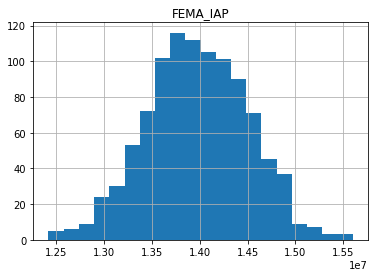

In [ ]:
df_Sources.hist('FEMA_IAP',bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ed28072d0>]],
      dtype=object)

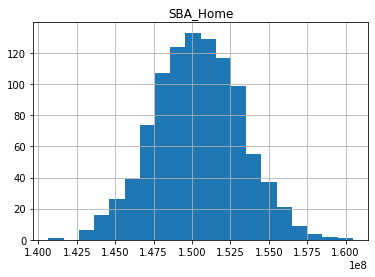

In [ ]:
df_Sources.hist('SBA_Home',bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ed27dcb90>]],
      dtype=object)

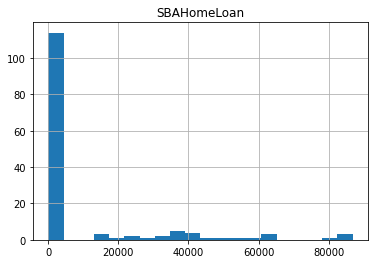

In [ ]:
df_last_sim.hist('SBAHomeLoan',bins=20)



---



---



In [ ]:
stop here

SyntaxError: ignored



---



---




# Figures

In [ ]:
df_Loss = pd.read_csv(data_dir+'Results_HCD/2017_Fires_Loss_Low.txt')
df_Unmet = pd.read_csv(data_dir+'Results_HCD/2017_Fires_Unmet_Low.txt')
df_Sources = pd.read_csv(data_dir+'Results_HCD/2017_Fires_Sources_Low.txt')

In [ ]:
# Total Loss
df_Loss['Mean'].sum()/10**9

In [ ]:
# FEMA IAP
print('Total from FEMA IAP:',df_Sources['FEMA_IAP'].mean()/0.79/10**6) # housing represents 79% of total from FEMA
print('Total FEMA IAP for homeowners:',df_Sources['FEMA_IAP'].mean()/10**6)
print('Mean FEMA IAP grant:',1/0.79*df_Sources['FEMA_IAP'].mean()/3048)
print('From FEMA Website',(4.189 + 11.058))#*cpi.inflate(1,2018,to=2021))

In [ ]:
print('Total from SBA HPPL:',df_Sources['SBA_Home'].mean()/10**6)
print('Average SBA HPPL loan:',df_Sources['SBA_Home'].mean()/1406)
print('Average SBA HPPL loan:',df_Sources['SBA_Home'].median()/1406)

In [ ]:
# Total unmet needs
print('The total loss is:',(df_Loss['Mean'].sum()-df_Sources['FEMA_IAP'].mean()-df_Sources['SBA_Home'].mean())/10**6)

### Losses


In [ ]:
df_Loss_Comparison = pd.read_csv(data_dir+'Fig_LossComparison.txt')
df_Loss_Haz = pd.read_csv(data_dir+'Results_No_Insured/2017_Fires_Loss_Hazus.txt')

df = pd.DataFrame()
df['Buildings'] = df_Loss_Comparison['Buildings'].apply(lambda x: '(0,100]' if x <100 else ('(100-500]' if x < 500 else '>500'))
df['SBA Losses'] = df_Loss_Comparison['SBA Losses']
df['HCD'] = [300] * len(df.index)
df['Hazus'] = df_Loss_Haz['Mean'].div(1000) / df_Loss_Comparison['Buildings']
df_Loss_Comparison_long = pd.melt(df,id_vars=['Buildings','SBA Losses'])
df_Loss_Comparison_long
plot_base = ggplot(df_Loss_Comparison_long,aes(y='SBA Losses',x='value',color='variable',size='Buildings')) + geom_point() + geom_abline(slope=1,linetype='dashed')

# Plot clean
plot_clean = plot_base + theme_bw()
plot_clean = plot_clean + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=10),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1)
) +\
labs(color='Loss model')+\
scale_color_manual(values = ['black','red'])+\
scale_y_continuous(name = 'SBA losses per building [$1000]',limits=[50,450]) +\
scale_x_continuous(name = 'Estimated losses per building [$1000]',limits=[50,450])

ggsave(plot_clean, filename = 'Fig_LossComparison.pdf', path = '/content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/')


plot_clean

## Insurance

## FEMA IAP

In [ ]:
df_Sources

,Losses,FEMA_IAP,Insurance,SBA_Home,SBA_Prop
0,Based on CDI,14.852323,8.316190e+08,1.437803e+08,0
1,Based on CDI,14.051306,8.381035e+08,1.535405e+08,0
2,Based on CDI,14.674514,8.371953e+08,1.512875e+08,0
3,Based on CDI,13.159056,8.342066e+08,1.573177e+08,0
4,Based on CDI,14.766666,8.372115e+08,1.505560e+08,0
...,...,...,...,...,...
995,None insured,14.853912,0.000000e+00,1.725753e+08,0
996,None insured,14.641815,0.000000e+00,1.759116e+08,0
997,None insured,14.817520,0.000000e+00,1.726178e+08,0
998,None insured,14.596895,0.000000e+00,1.736547e+08,0


/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/Fig_FEMA_Results.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_histogram : Removed 6 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(ar

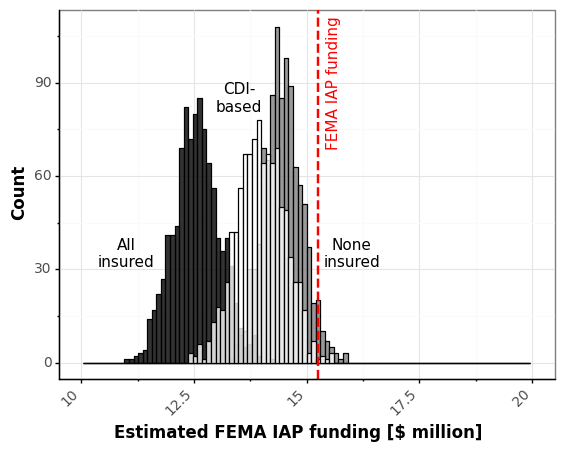

<ggplot: (8748506117957)>

In [ ]:
# FEMA results without insurance
df_Loss_None = pd.read_csv(data_dir+'Results_No_Insured/2017_Fires_Loss_Hazus.txt')
df_Unmet_None = pd.read_csv(data_dir+'Results_No_Insured/2017_Fires_Unmet_Hazus.txt')
df_Sources_None = pd.read_csv(data_dir+'Results_No_Insured/2017_Fires_Sources_Hazus.txt')

# FEMA results with all insurance
df_Loss_All = pd.read_csv(data_dir+'Results_Full_Insured/2017_Fires_Loss_Hazus.txt')
df_Unmet_All = pd.read_csv(data_dir+'Results_Full_Insured/2017_Fires_Unmet_Hazus.txt')
df_Sources_All = pd.read_csv(data_dir+'Results_Full_Insured/2017_Fires_Sources_Hazus.txt')

# FEMA results with partial insurance
df_Loss_Some = pd.read_csv(data_dir+'Results_Partial_Insured/2017_Fires_Loss_Hazus.txt')
df_Unmet_Some = pd.read_csv(data_dir+'Results_Partial_Insured/2017_Fires_Unmet_Hazus.txt')
df_Sources_Some = pd.read_csv(data_dir+'Results_Partial_Insured/2017_Fires_Sources_Hazus.txt')


# Tag
df_Sources_None['Losses'] = ['None insured'] * len(df_Sources_None)
df_Sources_Some['Losses'] = ['Based on CDI'] * len(df_Sources_Some)
df_Sources_All['Losses'] = ['All insured'] * len(df_Sources_All)
df_Sources = df_Sources_None.append(df_Sources_Some).append(df_Sources_All)

df_Sources['Losses'] = pd.Categorical(df_Sources['Losses'],categories=['None insured','All insured','Based on CDI'])

# Combine
df_Sources['FEMA_IAP'] = df_Sources['FEMA_IAP'].div(1000000)

# Base plot
plot_base = ggplot(df_Sources,aes(x='FEMA_IAP',group='Losses',fill='Losses'))\
            + geom_histogram(bins=100,position='identity',color='black',alpha=0.8)\
            + geom_vline(aes(xintercept=4.189+11.058), linetype='dashed', color='red',size=1)\
            + annotate('text', x=4.189+11.4, y = 90, label='FEMA IAP funding',color='red',angle=90)\
            + annotate('text', x=11, y = 35, label='All\ninsured',color='black')\
            + annotate('text', x=13.5, y = 85, label='CDI-\nbased',color='black')\
            + annotate('text', x=16, y = 35, label='None\ninsured',color='black')
            #+ geom_vline(aes(xintercept=20.7), linetype='dashed', color='red',size=1)\
            #+ annotate('text', x=20, y = 125, label='HCD-reported FEMA IAP funding',color='red',angle=90)\

# Clean plot
plot_clean = plot_base + theme_bw()
plot_clean = plot_clean + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=10),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1),
    legend_position = 'none'
) +\
labs(fill='Losses')+\
scale_fill_manual(values = ['gray','black','white'])+\
scale_x_continuous(name = 'Estimated FEMA IAP funding [$ million]',limits=[10,20]) +\
scale_y_continuous(name = 'Count')

ggsave(plot_clean, filename = 'Fig_FEMA_Results.pdf', path = '/content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/')

plot_clean

## SBA

/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/Fig_SBA_Hazus_vs_HCD.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_histogram : Removed 6 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorica

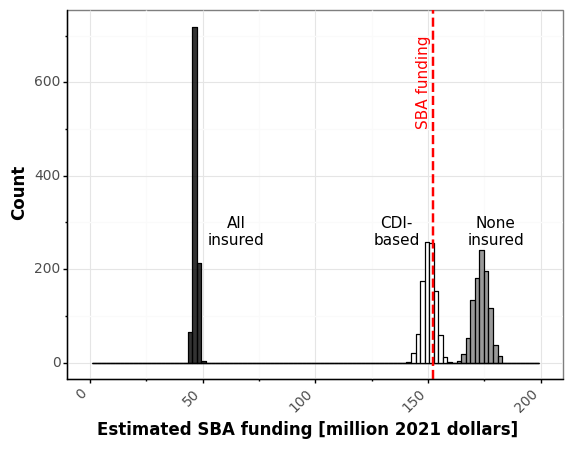

<ggplot: (8748506378713)>

In [ ]:
# SBA results without insurance
df_Loss_None = pd.read_csv(data_dir+'Results_No_Insured/2017_Fires_Loss_Hazus.txt')
df_Unmet_None = pd.read_csv(data_dir+'Results_No_Insured/2017_Fires_Unmet_Hazus.txt')
df_Sources_None = pd.read_csv(data_dir+'Results_No_Insured/2017_Fires_Sources_Hazus.txt')

# SBA results with all insurance
df_Loss_All = pd.read_csv(data_dir+'Results_Full_Insured/2017_Fires_Loss_Hazus.txt')
df_Unmet_All = pd.read_csv(data_dir+'Results_Full_Insured/2017_Fires_Unmet_Hazus.txt')
df_Sources_All = pd.read_csv(data_dir+'Results_Full_Insured/2017_Fires_Sources_Hazus.txt')

# SBA results with partial insurance
df_Loss_Some = pd.read_csv(data_dir+'Results_Partial_Insured/2017_Fires_Loss_Hazus.txt')
df_Unmet_Some = pd.read_csv(data_dir+'Results_Partial_Insured/2017_Fires_Unmet_Hazus.txt')
df_Sources_Some = pd.read_csv(data_dir+'Results_Partial_Insured/2017_Fires_Sources_Hazus.txt')


# Tag
df_Sources_None['Losses'] = ['None insured'] * len(df_Sources_None)
df_Sources_Some['Losses'] = ['Partially insured'] * len(df_Sources_Some)
df_Sources_All['Losses'] = ['All insured'] * len(df_Sources_All)
df_Sources = df_Sources_None.append(df_Sources_Some).append(df_Sources_All)


# Combine
df_Sources['SBA_Home'] = df_Sources['SBA_Home'].div(1000000)

# Plot base
plot_base = ggplot(df_Sources,aes(x='SBA_Home',group='Losses',fill='Losses'))\
            + geom_histogram(bins=100,position='identity',alpha=0.8,color='black')\
            + geom_vline(aes(xintercept=cpi.inflate(152,2018,to=2018)), linetype='dashed', color='red',size=1)\
            + annotate('text', x=148, y = 600, label='SBA funding',color='red', angle=90)\
            + annotate('text', x=65, y = 280, label='All\ninsured',color='black')\
            + annotate('text', x=180, y = 280, label='None\ninsured',color='black')\
            + annotate('text', x=136, y = 280, label='CDI-\nbased',color='black')
            #+ geom_vline(aes(xintercept=cpi.inflate(163,2018,to=2018)), linetype='dashed', color='red',size=1)\
            #+ annotate('text', x=159, y = 200, label='HCD-reported SBA funding',color='red', angle=90)\

# Plot clean
plot_clean = plot_base + theme_bw()
plot_clean = plot_clean + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=10),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1),
    legend_position='none'
) +\
labs(fill='Insurance')+\
scale_fill_manual(values = ['black','gray','white'])+\
scale_x_continuous(name = 'Estimated SBA funding [million 2021 dollars]',limits=[0,200]) +\
scale_y_continuous(name = 'Count')

ggsave(plot_clean, filename = 'Fig_SBA_Hazus_vs_HCD.pdf', path = '/content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/')

plot_clean

In [ ]:
df_SBA_2018[df_SBA_2018['Damaged Property State Code']=='CA'].groupby(by='Damaged Property County/Parish Name').sum()

/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/Fig_SBA_PerCounty.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/scales/scale_size.py:50: PlotnineWarning: Using alpha for a discrete variable is not advised.
  PlotnineWarning
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/usr/local/lib/python3.7/dist-packages/plotnine/utils.p

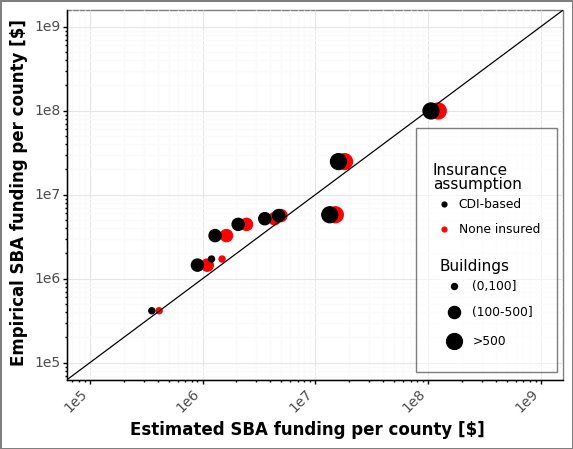

<ggplot: (8748532151785)>

In [ ]:
df_Loss_Comparison = pd.read_csv(data_dir+'Fig_LossComparison.txt')

df_Sources_None = pd.read_csv(data_dir+'Results_No_Insured/2017_Fires_HPPL_Hazus.txt')
df_Sources_Some = pd.read_csv(data_dir+'Results_Partial_Insured/2017_Fires_HPPL_Hazus.txt')


df = pd.DataFrame()
Counties = ['Butte', 'Lake','Los Angeles', 'Mendocino', 'Napa', 'Nevada', 'San Diego', 'Santa Barbara', 'Sonoma', 'Ventura', 'Yuba']
df['Counties'] = Counties
df['Buildings'] = df_Loss_Comparison['Buildings'].apply(lambda x: '(0,100]' if x <100 else ('(100-500]' if x < 500 else '>500'))
df['Approved funding'] = list([415900,1452800,1716800,5188300,5779200,92900,4441900,5649900,99480400,24812700,3263500])
df['None insured'] = df_Sources_None['Mean']
df['CDI-based'] = df_Sources_Some['Mean']

df_long = pd.melt(df,id_vars=['Counties','Buildings','Approved funding'])

plot_base = ggplot(df_long,aes(y='Approved funding',x='value',group='variable',color='variable',size='Buildings')) +\
            geom_point() +\
            geom_abline(slope=1)

# Plot clean
plot_clean = plot_base + theme_bw()
plot_clean = plot_clean + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=10),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1),
    legend_position = (0.78,0.38),
    legend_key=element_rect(color = 'white'),
    rect=element_rect(color='black',fill='white',alpha=0.5)
) +\
labs(color='Insurance\nassumption\n')+\
scale_color_manual(values = ['black','red'])+\
scale_y_log10(name = 'Empirical SBA funding per county [$]', limits=[10**5,10**9]) +\
scale_x_log10(name = 'Estimated SBA funding per county [$]', limits=[10**5,10**9])

ggsave(plot_clean, filename = 'Fig_SBA_PerCounty.pdf', path = '/content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/')


plot_clean



---



---



## Unmet housing needs

/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/Fig_UnmetHousingNeeds_Hist.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_histogram : Removed 6 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_cate

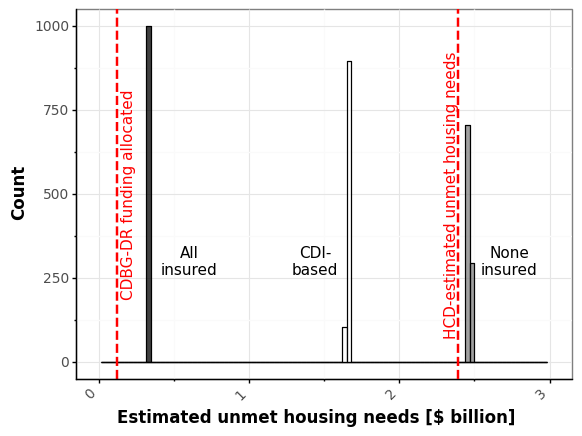

<ggplot: (8748506860693)>

In [ ]:
# SBA results without insurance
df_Sources_None = pd.read_csv(data_dir+'Results_No_Insured/2017_Fires_Sources_Hazus.txt')
df_Sources_None['Unmet'] = df_Sources_None['Losses'] - df_Sources_None['FEMA_IAP'] - df_Sources_None['SBA_Home'] - df_Sources_None['Insurance']
df_Sources_None['Unmet'] = df_Sources_None['Unmet'].div(10**9)
df_Sources_None['Tag'] = ['None insured'] * len(df_Sources_None.index)

# SBA results with all insurance
df_Sources_All = pd.read_csv(data_dir+'Results_Full_Insured/2017_Fires_Sources_Hazus.txt')
df_Sources_All['Unmet'] = df_Sources_All['Losses'] - df_Sources_All['FEMA_IAP'] - df_Sources_All['SBA_Home'] - df_Sources_All['Insurance']
df_Sources_All['Unmet'] = df_Sources_All['Unmet'].div(10**9)
df_Sources_All['Tag'] = ['All insured'] * len(df_Sources_All.index)

# SBA results with partial insurance
df_Sources_Some = pd.read_csv(data_dir+'Results_Partial_Insured/2017_Fires_Sources_Hazus.txt')
df_Sources_Some['Unmet'] = df_Sources_Some['Losses'] - df_Sources_Some['FEMA_IAP'] - df_Sources_Some['SBA_Home'] - df_Sources_Some['Insurance']
df_Sources_Some['Unmet'] = df_Sources_Some['Unmet'].div(10**9)
df_Sources_Some['Tag'] = ['Some insured'] * len(df_Sources_Some.index)


# df_Unmet = pd.DataFrame()
# df_Unmet['Unmet'] = df_Sources_Haz['Losses'] - df_Sources_Haz['FEMA_IAP'] - df_Sources_Haz['SBA_Home']
# df_Unmet['Unmet'] = df_Unmet['Unmet'].div(10**9)
# df_Unmet['Tag'] = ['None insured'] * len(df_Unmet.index)

# df_Unmet_Ins = pd.DataFrame()
# df_Unmet_Ins['Unmet'] = df_Sources_Ins['Losses'] - df_Sources_Ins['FEMA_IAP'] - df_Sources_Ins['SBA_Home'] - df_Sources_Ins['Insurance']
# df_Unmet_Ins['Unmet'] = df_Unmet_Ins['Unmet'].div(10**9)
# df_Unmet_Ins['Tag'] = ['All insured'] * len(df_Unmet_Ins.index)

df_Unmet_All = df_Sources_None.append(df_Sources_All).append(df_Sources_Some)

# Plot base
plot_base = ggplot(df_Unmet_All,aes(x='Unmet',group='Tag',fill='Tag'))\
            + geom_histogram(bins=100,position='identity',alpha=0.75,color='black')\
            + geom_vline(aes(xintercept=0.124), linetype='dashed', color='red',size=1)\
            + geom_vline(aes(xintercept=2.394), linetype='dashed', color='red',size=1)\
            + annotate('text', x=0.20, y = 500, label='CDBG-DR funding allocated',color='red',angle=90)\
            + annotate('text', x=2.35, y = 500, label='HCD-estimated unmet housing needs',color='red',angle=90)\
            + annotate('text', x=0.6, y = 300, label='All\ninsured',color='black')\
            + annotate('text', x=2.73, y = 300, label='None\ninsured',color='black')\
            + annotate('text', x=1.44, y = 300, label='CDI-\nbased',color='black')

# Plot clean
plot_clean = plot_base + theme_bw()
plot_clean = plot_clean + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=10),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1),
    legend_position='none'
) +\
labs(fill='Insurance')+\
scale_fill_manual(values = ['black','gray','white'])+\
scale_x_continuous(name = 'Estimated unmet housing needs [$ billion]',limits=[0,3]) +\
scale_y_continuous(name = 'Count')

ggsave(plot_clean, filename = 'Fig_UnmetHousingNeeds_Hist.pdf', path = '/content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/')

plot_clean

In [ ]:
df_Loss_Haz = pd.read_csv(data_dir+'Results_HazusRC/2017_Fires_Loss_Hazus.txt')
df_FEMAIAP = pd.read_csv(data_dir+'Results_HazusRC/2017_Fires_IAP_Hazus.txt')
df_SBAHPPL = pd.read_csv(data_dir+'Results_HazusRC/2017_Fires_HPPL_Hazus.txt')
df_Unmet_Haz = pd.read_csv(data_dir+'Results_HazusRC/2017_Fires_Unmet_Hazus.txt')

df = pd.DataFrame()

Counties = ['Butte', 'Lake','Los Angeles', 'Mendocino', 'Napa', 'Nevada', 'San Diego', 'Santa Barbara', 'Sonoma', 'Ventura', 'Yuba']
df['Counties'] = Counties
df['Buildings'] = df['Counties'].map(dic_destroyed) + df['Counties'].map(dic_damaged)
df['Received'] = df_FEMAIAP['Mean'] + df_SBAHPPL['Mean']
df['Received'] = df['Received']/df['Buildings']
df['Unmet'] = df_Unmet_Haz['Mean'] / df_Loss_Haz['Mean'].apply(lambda x: cpi.inflate(x,2018,to=2021))
df['Home Value'] = df['Counties'].map(dic_home_val)

plot_base = ggplot(df,aes(x='Received',y='Unmet',color='Home Value')) + geom_point(size=4) 

# Plot clean
plot_clean = plot_base + theme_bw()
plot_clean = plot_clean + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=10),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1)
) +\
scale_x_continuous(name = 'Assistance received per building [$]\n(FEMA IAP + SBA HPPL)') +\
scale_y_continuous(name = 'Unmet needs/\nTotal losses')

ggsave(plot_clean, filename = 'Fig_UnmetHousingNeeds_Disparity.pdf', path = '/content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/')

plot_clean



---



---

